Importa o modelo a ser fatiado e mapeado

In [4]:
import matplotlib.pyplot as plt
import gui
import files
from timer import Timer
from components.layer import Layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
choice = gui.ask_load_or_begin()
if choice == "Novo Projeto":
    path_input, file_name = gui.load_model(folders)
    [dpi, layer_height] = gui.ask_parameters_input()
    with Timer("Fase 0: "):
        Layer.create_layers(folders, path_input, file_name, dpi, layer_height)
elif choice == "Carregar Salvo":
    gui.find_saved_file(folders)
elif choice == "Cancelar":
    quit

#TODO: encontrar uma forma de jogar layerHight para o slicing W/images (POSSIVELMENTE COM O RUNSINGLEMODEL)

Fase 0: 
criando as camadas
Total de [criando as camadas] : 0.3016242980957031
salvando as camadas
Total de [salvando as camadas] : 0.10882282257080078
Total de [Fase 0: ] : 0.41083407402038574


Paredes Finas

In [5]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[nozzle_diam_internal,nozzle_diam_external] = gui.ask_parameters_thin_walls()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 1: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_thin_walls(folders, nozzle_diam_external, nozzle_diam_internal)
        %reset_selective -f "c"
%reset_selective -f "camadas"
# TODO: arvore de paredes finas
# TODO: quando duas áreas se encontram
# TODO: limite de parede diam minimo
# TODO: anotar todos os (não fechou contorno)
# TODO arrumar para origens extremamente pequenas, ignorar da problema
# TODO arrumar casos onde a beirada esta vazndo criando areas triangulares distantes
# FIXME: Precisa mesmo separar linha 1 2 topo e baixo? muitos elementos estão sendo criados

Fase 1: Camada: 0
Criando paredes finas
Total de [Criando paredes finas] : 18.33269739151001
Retirando Paredes finas da camada
Total de [Retirando Paredes finas da camada] : 0.0016717910766601562
salvando imagens das regiões
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.17377376556396484
Total de [Fase 1: Camada: 0] : 18.58012843132019


Contornos

In [6]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[void_max,internal_max,external_max] = gui.ask_parameters_offsets()
camadas = folders.load_layers_hdf5()
for i,c in enumerate(camadas):
    with Timer("Fase 2: Camada: " + str(i)):
        folders.load_islands_hdf5(c)
        c.make_offsets(folders, void_max, external_max, internal_max)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 2: Camada: 0
Criando Lvls
Ilha: I_000 Número de Níveis: 9
Total de [Criando Lvls] : 7.874182939529419
Criando os loops
Total de [Criando os loops] : 4.493923902511597
Criando regiões de influência
Total de [Criando regiões de influência] : 1.132054090499878
Criando as regiões de Offset
Total de [Criando as regiões de Offset] : 2.9887237548828125
Retirando regiões da camada
['Lvl_000', 0, 0] Perdendo total:2382 maior void:0.33877038895859474Bw -> aceito
['Lvl_001', 0, 0] Perdendo total:1929 maior void:0.5872020075282308Bw -> aceito
['Lvl_002', 0, 0] Perdendo total:1636 maior void:0.5131744040150564Bw -> aceito
['Lvl_003', 0, 0] Perdendo total:1637 maior void:0.5131744040150564Bw -> aceito
['Lvl_004', 0, 0] Perdendo total:9614 maior void:5.503136762860728Bw -> bloqueado
['Lvl_000', 1, 0] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 1] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 2] Perdendo total:0 maior void:0Bw -> aceito
['Lvl_000', 1, 3] Perdendo total:442

Pontes

In [7]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd
import numpy as np
from components import images_tools as it

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[n_max, nozzle_diam_internal] = gui.ask_parameters_bridges()
camadas = folders.load_layers_hdf5()
last_prohibited_areas = np.zeros(camadas[0].base_frame)
for i,c in enumerate(camadas):
    with Timer("Fase 3: Camada: " + str(i)):
        if i%2 == 1:
            last_image = it.rotate_img_cw(last_prohibited_areas )
        elif i%2 == 0:
            last_image = it.rotate_img_ccw(last_prohibited_areas )
        if i >= 2:
            if i%2 == 1:
                second_last_image = it.rotate_img_cw(camadas[i - 1].prohibited_areas)
            elif i%2 == 0:
                second_last_image = it.rotate_img_ccw(camadas[i - 1].prohibited_areas)
        else:
            second_last_image = np.zeros_like(last_image)
        c.prohibited_areas = last_image
        sum_prohibited_areas = it.sum_imgs([last_image, second_last_image])
        last_prohibited_areas = c.make_bridges(n_max, nozzle_diam_internal, folders, len(camadas), sum_prohibited_areas)
        folders.save_props_hdf5(f"/{c.name}",c.__dict__)
        # %reset_selective -f "c" 
# %reset_selective -f "camadas"

Fase 3: Camada: 0
Criando pontes de Offset
Total de [Criando pontes de Offset] : 19.277873516082764
Criando pontes de Zigzag
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
teste: caso de uma unica linha no entorno da origem
[3#mFechou uma ponte OK
[3#mFechou uma ponte OK
Total de [Criando pontes de Zigzag] : 52.064568519592285
Criando pontes de Crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqui eu não deixei a parede unica virar crossover
Aqu

Zigzags

In [8]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        c.make_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"


Fase 4: Camada: 0
Encontrando areas monotonicas
Total de [Encontrando areas monotonicas] : 17.82557964324951
salvando imagens das regiões
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
ERRO: não deletou a coisa
Total de [salvando imagens das regiões] : 0.18402409553527832
Total de [Fase 4: Camada: 0] : 18.981361389160156


Fase 4: Camada: 0


Total de [Fase 4: Camada: 0] : 1.7025580406188965


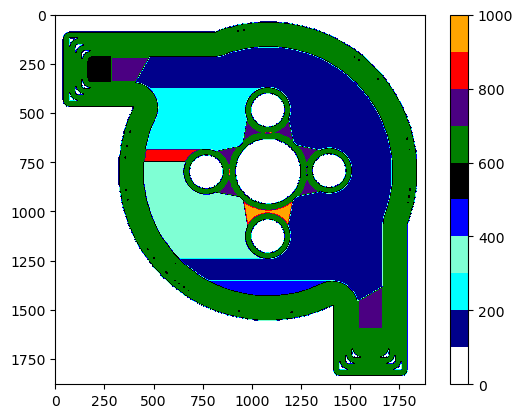

In [9]:
import gui
import files
from timer import Timer
from components import images_tools as it
from os import getcwd
import matplotlib.pyplot as plt
import matplotlib.colors
import os

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5() 
for c in camadas:
    folders.load_islands_hdf5(c)
tangran_cmap = matplotlib.colors.ListedColormap(["white","darkblue","aqua","aquamarine","blue","black","green","indigo","red","orange"])
for i, c in enumerate(camadas):
    with Timer("Fase 4: Camada: " + str(i)):
        plt.figure()
        img_mapping = it.final_mapping(c, folders)
        if i%2 == 1:
            img_mapping = it.rotate_img_ccw(img_mapping )
        plt.imshow(img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        # plt.imsave("aaa.png",img_mapping, cmap=tangran_cmap, vmin=0, vmax=1000)
        plt.colorbar()
        print('\n')

ROTAS

Rotas de Offset

In [10]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

amendment_size = 0.7 #porcentagem do tamanho da poca de deposicao de material
for c in camadas:
    with Timer("Making offset routes"):
        c.make_offset_routes(amendment_size, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making offset routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.39312148094177246
Total de [Making offset routes] : 14.140685319900513


Rotas de pontes

In [11]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making bridges routes"):
        c.make_bridges_routes(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Making bridges routes
salvando imagens das rotas
Total de [salvando imagens das rotas] : 0.6441211700439453
Total de [Making bridges routes] : 72.32255029678345


Rotas de Ziguezague

In [1]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Making zigzag routes"):
        c.make_zigzag_routes(folders)
        c.connect_zigzags(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"



Making zigzag routes
criando as rotas de zigzag, camada:L_000
fazendo as tres opções:
Total de [fazendo as tres opções:] : 21.271220684051514
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.43099427223205566
fazendo as tres opções:
Total de [fazendo as tres opções:] : 18.564621448516846
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.44232606887817383
fazendo as tres opções:
Total de [fazendo as tres opções:] : 15.19971752166748
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4316408634185791
fazendo as tres opções:
Total de [fazendo as tres opções:] : 0.07275915145874023
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.1994941234588623
fazendo as tres opções:
Total de [fazendo as tres opções:] : 32.03543782234192
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.793632984161377
fazendo as tres opções:
Total de [fazendo as tres opções:] : 30.599608898162842
escolhendo entre elas:
Total de [escolhendo entre elas:] : 0.4361128

WEAVING

In [14]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
[iwflag] = gui.ask_parameters_weaving()
for c in camadas:
    with Timer("Fase 5 b"):
        c.internal_weaving(iwflag, folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5 b
gerando preenchimentos oscilatórios
Pegando as falhas internas
Total de [Pegando as falhas internas] : 2.906784772872925
Achando os contatos
Total de [Achando os contatos] : 32.72154116630554
criando os weavings
falhou um weaving aqui!
Total de [criando os weavings] : 19.474261045455933
Total de [gerando preenchimentos oscilatórios] : 60.71044635772705
salvando rotas
deletado: /L_000/I_000/zigzags/macro_areas
Total de [salvando rotas] : 0.5327680110931396
Total de [Fase 5 b] : 61.24423551559448


Rotas de Thin Walls

In [15]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()
for c in camadas:
    with Timer("Fase 5"):
        with Timer("Making thin walls routes"):
            c.make_thin_wall_routes(folders)
            %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 5
Making thin walls routes
criando rotas TW
Total de [criando rotas TW] : 0.12639069557189941
salvando imagens das rotas
Total de [salvando imagens das rotas] : 7.867813110351562e-06
Total de [Making thin walls routes] : 0.12672781944274902
Total de [Fase 5] : 0.12686753273010254


Unificando rotas EXTERNAS nas camadas

In [16]:
import gui
import files
from timer import Timer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 6"):
        c.close_routes_external(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"
    

Fase 6
Conectando rotas externas
Conectando pontes de Offset
Total de [Conectando pontes de Offset] : 17.282333374023438
Conectando pontes de Crossover
salto:  [1053, 1015]
Total de [Conectando pontes de Crossover] : 0.863971471786499
Total de [Conectando rotas externas] : 20.770029067993164
salvando imagens das rotas
deletado: /L_000/I_000/external_tree_route
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.3782048225402832
Total de [Fase 6] : 21.148796558380127


Unificando rotas INTERNAS nas camadas

In [17]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 7"):
        c.close_routes_internal(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 7
Conectando zgzags vizinhos
Total de [Conectando zgzags vizinhos] : 11.916200399398804
Conectando pontes de zigzag
salto:  [250, 270]
salto:  [1616, 1573]
Total de [Conectando pontes de zigzag] : 3.080305337905884
salvando imagens das rotas
deletado: /L_000/I_000/internal_tree_route
Total de [salvando imagens das rotas] : 0.3949575424194336
Total de [Fase 7] : 17.619537830352783


Unindo rotas de thin walls

In [18]:
import gui
import files
from timer import Timer
from components import layer
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    with Timer("Fase 8"):
        c.close_routes_thinwalls(folders)
        %reset_selective -f "c"
%reset_selective -f "camadas"

Fase 8
Convertendo paredes finas
Total de [Convertendo paredes finas] : 0.0029458999633789062
salvando imagens das rotas
deletado: /L_000/I_000/thinwalls_tree_route/sequence
deletado: /L_000/I_000/thinwalls_tree_route/saltos
Total de [salvando imagens das rotas] : 0.21009182929992676
Total de [Fase 8] : 0.3027169704437256


Unindo todas as rotas

In [19]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
camadas = folders.load_layers_hdf5()

for c in camadas:
    c.close_final_path(folders)

%reset_selective -f "camadas"


Encontrando ponto de união ext-int
Total de [Encontrando ponto de união ext-int] : 0.6625070571899414
Conectando ambas as partes
Total de [Conectando ambas as partes] : 0.05307817459106445
salvando imagens das rotas
deletado: /L_000/I_000/island_route
ERRO: não deletou a coisa
Total de [salvando imagens das rotas] : 0.01189422607421875


Gerando o Código G

In [1]:
import gui
import files
from timer import Timer
from components import layer, path_tools
from os import getcwd

if not('folders' in globals()):
    home = getcwd()
    folders = files.System_Paths(home)
    gui.find_saved_file(folders)
[vel_int, vel_ext, vel_thin_wall, p_religamento, p_desligamento, vel_vazio, p_entre_camadas, substratoy, substratox, cortey, cortex] = gui.ask_parameters_Gcode()
coords_substrato = [substratoy, substratox]
coords_corte = [cortey, cortex]
camadas = folders.load_layers_hdf5()

layer_heights = [10+2.9+3+(i*1.5) for i,x in enumerate(camadas)]
with Timer("Cuspindo o Gcode"):
    path_tools.layers_to_Gcode(camadas, 
                               folders, 
                               vel_int,
                               vel_ext, 
                               vel_thin_wall, 
                               p_religamento,
                               p_desligamento,
                               vel_vazio,
                               p_entre_camadas,
                               layer_heights,
                               coords_substrato,
                               coords_corte,
                               )
%reset_selective -f "camadas"

Cuspindo o Gcode
trocou para 1
trocou para 0
deslocamento total da camada 0 = 939.4670306376552mm

tempo estimado com Vel=360.0mm/min = 2.609630640660153min

trocou para 1
trocou para 0
deslocamento total da camada 1 = 950.135183585442mm

tempo estimado com Vel=360.0mm/min = 2.6392643988484497min

trocou para 1
trocou para 0
deslocamento total da camada 2 = 941.222967143864mm

tempo estimado com Vel=360.0mm/min = 2.614508242066289min

trocou para 1
trocou para 0
deslocamento total da camada 3 = 905.1156808326971mm

tempo estimado com Vel=360.0mm/min = 2.5142102245352698min

trocou para 1
trocou para 0
deslocamento total da camada 4 = 903.1905735305301mm

tempo estimado com Vel=360.0mm/min = 2.5088627042514724min

trocou para 1
trocou para 0
deslocamento total da camada 5 = 901.793699049467mm

tempo estimado com Vel=360.0mm/min = 2.5049824973596304min

trocou para 1
trocou para 0
deslocamento total da camada 6 = 937.3497752232634mm

tempo estimado com Vel=360.0mm/min = 2.603749375620176

In [21]:
import numpy as np
camadas = folders.load_layers_hdf5()
for c in camadas:
    folders.load_islands_hdf5(c)
    for isl in c.islands:
        folders.load_island_paths_hdf5(c.name, isl)
        internal_trees = [list(x) for x in isl.internal_tree_route.sequence]
        print(internal_trees)
print([235,807] in internal_trees)

[[1426, 1572], [1426, 1573], [1425, 1574], [1424, 1575], [1424, 1576], [1423, 1577], [1423, 1578], [1422, 1579], [1421, 1580], [1421, 1581], [1420, 1582], [1420, 1583], [1419, 1584], [1418, 1584], [1417, 1584], [1416, 1584], [1415, 1584], [1414, 1584], [1413, 1584], [1412, 1584], [1411, 1584], [1410, 1584], [1409, 1584], [1408, 1584], [1407, 1584], [1406, 1584], [1405, 1584], [1404, 1584], [1403, 1584], [1402, 1584], [1401, 1584], [1400, 1584], [1399, 1584], [1398, 1584], [1397, 1584], [1396, 1584], [1395, 1584], [1394, 1584], [1393, 1584], [1392, 1584], [1391, 1584], [1390, 1584], [1389, 1584], [1388, 1584], [1387, 1583], [1386, 1582], [1385, 1581], [1384, 1580], [1383, 1579], [1382, 1578], [1381, 1577], [1380, 1576], [1379, 1576], [1378, 1576], [1377, 1577], [1376, 1578], [1375, 1579], [1374, 1580], [1373, 1581], [1372, 1582], [1371, 1583], [1370, 1584], [1369, 1585], [1369, 1586], [1369, 1587], [1369, 1588], [1369, 1589], [1369, 1590], [1369, 1591], [1369, 1592], [1369, 1593], [1369

In [22]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import numpy as np

# # Lista de imagens binárias (exemplo com arrays numpy)
# imagens = [
#     img_mapping,
#     img_mapping,
#     img_mapping
# ]

# # Lista de alturas no eixo z
# alturas = [0, 10, 20]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for img, z in zip(imagens, alturas):
#     x = np.linspace(0, img.shape[1], img.shape[1])
#     y = np.linspace(0, img.shape[0], img.shape[0])
#     x, y = np.meshgrid(x, y)
#     z = np.full_like(x, z)
#     ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=plt.cm.gray(img), shade=False)

# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()


In [23]:
# import gui
# import files
# from timer import Timer
# from components import layer, path_tools
# from os import getcwd

# if not('folders' in globals()):
#     home = getcwd()
#     folders = files.System_Paths(home)
#     gui.find_saved_file(folders)
# camadas = folders.load_layers_hdf5()

# file_name = gui.find_saved_file(folders)
# path_tools.layers_to_Gcode_FFF(camadas, folders, file_name)

In [24]:
class TrafficLightState:
    """Base class for traffic light states."""
    def change(self, traffic_light):
        raise NotImplementedError("This method should be overridden by subclasses")


class RedState(TrafficLightState):
    """State representing the red light."""
    def change(self, traffic_light):
        print("Changing from Red to Green")
        traffic_light.state = GreenState()


class YellowState(TrafficLightState):
    """State representing the yellow light."""
    def change(self, traffic_light):
        print("Changing from Yellow to Red")
        traffic_light.state = RedState()


class GreenState(TrafficLightState):
    """State representing the green light."""
    def change(self, traffic_light):
        print("Changing from Green to Yellow")
        traffic_light.state = YellowState()


class TrafficLight:
    """Traffic light class that uses a state machine."""
    def __init__(self):
        self.state = RedState()  # Initial state

    def change(self):
        """Change the state of the traffic light."""
        self.state.change(self)

    def __str__(self):
        return f"Current state: {self.state.__class__.__name__}"


# Example usage
if __name__ == "__main__":
    traffic_light = TrafficLight()
    
    # Simulate the traffic light changing states
    for _ in range(6):  # Change state 6 times
        print(traffic_light)
        traffic_light.change()

Current state: RedState
Changing from Red to Green
Current state: GreenState
Changing from Green to Yellow
Current state: YellowState
Changing from Yellow to Red
Current state: RedState
Changing from Red to Green
Current state: GreenState
Changing from Green to Yellow
Current state: YellowState
Changing from Yellow to Red


In [25]:
import numpy as np
import cv2  # Assuming you are using OpenCV for image processing

def bobobo(image1, image2):
    """A placeholder function that performs some operation on two images."""
    # For demonstration, let's just return the absolute difference between the two images
    return cv2.absdiff(image1, image2)

def process_images(image_list):
    """Process a list of images, comparing the last two with the current image."""
    for i in range(len(image_list)):
        current_image = image_list[i]
        
        # Check if there are at least two previous images to compare
        if i >= 2:
            last_image = image_list[i - 1]
            second_last_image = image_list[i - 2]
            
            # Apply the bobobo function to the current image and the last two images
            result_last = bobobo(current_image, last_image)
            result_second_last = bobobo(current_image, second_last_image)
            
            # Here you can do something with the results, like saving or displaying them
            # For demonstration, we'll just print the shapes of the results
            print(f"Comparing image {i} with last image {i-1}: result shape = {result_last.shape}")
            print(f"Comparing image {i} with second last image {i-2}: result shape = {result_second_last.shape}")

# Example usage
if __name__ == "__main__":
    # Create a list of dummy images (for demonstration purposes)
    # In practice, you would load your images using cv2.imread or similar
    image_list = [np.random.randint(0, 256, (100, 100, 3), dtype=np.uint8) for _ in range(5)]
    
    process_images(image_list)

Comparing image 2 with last image 1: result shape = (100, 100, 3)
Comparing image 2 with second last image 0: result shape = (100, 100, 3)
Comparing image 3 with last image 2: result shape = (100, 100, 3)
Comparing image 3 with second last image 1: result shape = (100, 100, 3)
Comparing image 4 with last image 3: result shape = (100, 100, 3)
Comparing image 4 with second last image 2: result shape = (100, 100, 3)
